In [1]:
import os
import cv2
from PIL import Image
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
#from torch.optim.lr_scheduler import _LRScheduler

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision import models
from torchsummary import summary
import torch.nn.functional as F


/home/MMI24limbyungwan/.conda/envs/byungwan_resn/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# GPU 사용이 가능할 경우, GPU를 사용할 수 있게 함.'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

print(os.environ.get('CUDA_VISIBLE_DEVICES'))

cuda
2


In [3]:
# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# 클래스별 IoU를 계산하기 위한 함수
def calculate_iou_per_class(y_true, y_pred, class_id):
    intersection = np.sum((y_true == class_id) & (y_pred == class_id))
    union = np.sum((y_true == class_id) | (y_pred == class_id))
    iou = intersection / union if union > 0 else 0
    return iou

def normalize_image(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # 이미지를 0과 1 사이의 값으로 스케일 조정
    normalized_image = image / 255.0
    
    # 평균을 빼고 표준 편차로 나누어 정규화
    normalized_image = (normalized_image - mean) / std
    
    return normalized_image


In [8]:
background = cv2.imread('./background.png')
image = cv2.imread('./data/224/train_source_image/TRAIN_SOURCE_0000.png')
h,w,_ = image.shape
background = cv2.resize(background, (h,w))
background_mask = background[:,:,0]

In [9]:
def make_bumper_std(image, mask):
    h,w,_ = image.shape
    background = cv2.imread('./background.png')
    background = cv2.resize(background, (h,w))
    background_mask = background[:,:,0]

    target_image = cv2.imread('./data/224/target_val_image/svm_front_2021-06-04-14-37-37_00000000.png')
    target_mask = cv2.imread('./data/224/target_val_gt/svm_front_2021-06-04-14-37-37_00000000.png')

    bumper_image = image * background + target_image * (1-background)
    bumper_mask = mask * background_mask + target_mask * (1-background_mask)
    

In [4]:
def make_bumper(image, mask):
    h,w,c = image.shape
    center = (w//2, int(h*0.375))  # x,y
    axis_length = (w//2, int(h*0.64))  # 장축 반지름과 단축 반지름

    # 타원 그리기 (타원을 1로 채우고 나머지 부분은 0으로 채움)
    oval = np.zeros((h,w,1),dtype=np.uint8)
    cv2.ellipse(oval, center, axis_length, 0, 0, 360, 1, -1)

    target_image_path = './data/224/train_target_image/TRAIN_TARGET_0001.png'
    target_image = cv2.imread(target_image_path, cv2.IMREAD_COLOR)
    target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)
    target_image = normalize_image(target_image)

    mixed_image = image * oval + target_image * (1-oval)
    mixed_mask = mask * oval[:,:,0] + np.ones_like(mask)*0*(1-oval[:,:,0])

    return mixed_image, mixed_mask



In [ ]:
def make_bumper_std(image, mask):
    h,w,_ = image.shape
    background = cv2.imread('./background.png')
    background = cv2.resize(background, (h,w))
    background_mask = background[:,:,0]

    target_image = cv2.imread('./data/224/target_val_image/svm_front_2021-06-04-14-37-37_00000000.png')
    target_mask = cv2.imread('./data/224/target_val_gt/svm_front_2021-06-04-14-37-37_00000000.png')

    target_image = cv2.resize(target_image, (h,w))
    target_mask = cv2.resize(target_mask, (h,w))

    bumper_image = image * background + target_image * (1-background)
    bumper_mask = mask * background_mask + target_mask * (1-background_mask)

    
    return bumper_image, bumper_mask

In [5]:
import numpy as np
import cv2
import torch

def apply_fisheye_distortion(images, masks, label):
    # 이미지 크기 가져오기
    batch, channel, height, width = images.shape

    # 카메라 매트릭스 생성
    focal_length = width / 2
    center_x = width / 2
    center_y = height / 2
    camera_matrix = np.array([[focal_length, 0, center_x],
                              [0, focal_length, center_y],
                              [0, 0, 1]], dtype=np.float32)

    # 왜곡 계수 생성
    # dist_num = 0
    # if label == 1:
    #     dist_num = random.randint(1,3)
    # elif label == 2.5:
    #     dist_num = 2.5
    dist_num = label+1
    dist_coeffs = np.array([0, 0.03 * dist_num, 0, 0], dtype=np.float32)

    # 왜곡 보정
    undistorted_images = []
    undistorted_masks = []

    for i in range(batch):
        image = images[i].permute(1, 2, 0).cpu().numpy()  # 텐서를 NumPy 배열로 변환
        mask = masks[i].cpu().numpy()
        undistorted_image = cv2.undistort(image, camera_matrix, dist_coeffs)
        undistorted_mask = cv2.undistort(mask, camera_matrix, dist_coeffs)
        undistorted_mask = np.round(undistorted_mask).astype(np.uint8)
        undistorted_mask[undistorted_mask > 12] = 12

        undistorted_image, undistorted_mask = make_bumper_std(undistorted_image, undistorted_mask)

        #다시 텐서로 변환
        undistorted_image = torch.from_numpy(undistorted_image).permute(2, 0, 1).float().to(device)
        undistorted_mask = torch.from_numpy(undistorted_mask).long().to(device)

        undistorted_images.append(undistorted_image)
        undistorted_masks.append(undistorted_mask)

    undistorted_images = torch.stack(undistorted_images, dim=0)
    undistorted_masks = torch.stack(undistorted_masks, dim=0)

    return undistorted_images, undistorted_masks


In [6]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #directory_path = "/mnt/nas27/Dataset/Samsung_DM"
        directory_path = './data/224'
        img_path = self.data.iloc[idx, 1]
        img_path = os.path.join(directory_path, img_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image
        
        mask_path = self.data.iloc[idx, 2]
        mask_path = os.path.join(directory_path, mask_path)
        mask = cv2.imread(mask_path)
        #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = np.round(mask).astype(np.uint8)
        mask[mask > 12] = 12 #배경을 픽셀값 12로 간주
        mask += 1
        mask[mask == 13] = 0

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask
     

transform = A.Compose(
    [   
        #A.Resize(224, 224),
        #A.Resize(128, 128),
        A.Normalize(),
        A.GaussNoise(var_limit=(10.0, 30.0), p=0.3),
        
        # 변형
        A.VerticalFlip(p=0.5),
        # A.RandomRotate90(p=0.5),
        # A.HueSaturationValue(p=0.2),
        
        ToTensorV2()
    ]
)

## 기본 U-Net

In [7]:
# #Unet의 기본이 되는 conv블럭
# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(ConvBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.relu1 = nn.ReLU()
        
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)  # 여기서 in_channels는 out_channels와 동일해야 합니다.
#         self.bn2 = nn.BatchNorm2d(out_channels)
#         self.relu2 = nn.ReLU()

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu1(x)
        
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu2(x)
#         return x

# #인코더 블럭
# class EncoderBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(EncoderBlock,self).__init__()
#         self.convblock1 = ConvBlock(in_channels, out_channels)  # 첫 번째 ConvBlock의 in_channels는 입력 이미지의 채널 수와 일치해야 합니다.
#         #self.convblock2 = ConvBlock(out_channels, out_channels)  # 두 번째 ConvBlock의 in_channels는 out_channels와 일치해야 합니다.
#         self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

#     def forward(self,x):
#         x = self.convblock1(x)
#         #x = self.convblock2(x)
#         p = self.maxpool(x)
#         return x , p
# #디코더 블럭
# #디코더는 업샘플링 이후 스킵연결과 붙어서 convblock을 통과해야함
# #skip보다 작은 x x먼저 업샘플링 32 -> 64 , skip과 결합 6464 
# class DecoderBlock(nn.Module):
#     def __init__(self, channels):
#         super(DecoderBlock,self).__init__()
#         self.upsample = nn.ConvTranspose2d(channels*2, channels, kernel_size=4, stride=2, padding=1)#x 업샘플링
#         self.convblock1 = ConvBlock(channels*2, channels)#차원감소
#         #self.convblock2 = ConvBlock(channels, channels)
#     def forward(self,x,skip):
#         x = self.upsample(x)
#         x = torch.cat([x, skip], dim=1)
#         x = self.convblock1(x)
#         #x = self.convblock2(x)
#         return x

# ###########################################
# class GradReverse(torch.autograd.Function):
#     @staticmethod
#     def forward(self, x):
#         return x.view_as(x)
#     @staticmethod
#     def backward(self, grad_output): # 역전파 시에 gradient에 음수를 취함
#         return (grad_output * -1)

# class domain_classifier(nn.Module):
#     def __init__(self):
#         super(domain_classifier, self).__init__()
#         self.fc1 = nn.Linear(224*224*64, 10)
#         self.fc2 = nn.Linear(10, 4) # source = 0, target = 1 회귀 가정

#     def forward(self, x):
#         x = x.view(-1, 224*224*64)
#         x = GradReverse.apply(x) # gradient reverse
#         x = F.leaky_relu(self.fc1(x))
#         x = self.fc2(x)
        
#         return x

# ###########################################


# #Unet구조 middle의 xm값의 움직임에 주의
# class Unet(nn.Module):
#     def __init__(self,n_classes):
#         super(Unet,self).__init__()
#         self.encoder1 = EncoderBlock(3,64)
#         self.encoder2 = EncoderBlock(64,128)
#         self.encoder3 = EncoderBlock(128,256)
#         self.encoder4 = EncoderBlock(256,512)
        
#         self.middleconv = ConvBlock(512,1024)
        
        
#         self.decoder4 = DecoderBlock(512)
#         self.decoder3 = DecoderBlock(256)
#         self.decoder2 = DecoderBlock(128)
#         self.decoder1 = DecoderBlock(64)
#         self.segmap = nn.Conv2d(64,n_classes, kernel_size=1)
        
#         self.domain_classifier = domain_classifier()
                                        

#     def forward(self,x):
#         x1,p = self.encoder1(x)#3->64   #P:256,256 x1 :512,512
#         x2,p = self.encoder2(p)#64->128 #P:128,128 x2:256,256
#         x3,p = self.encoder3(p)#128->256#p:64,64 x3:128,128
#         x4,p = self.encoder4(p)#256->512#p:32,32 x4:64,64
        
#         xm = self.middleconv(p)#512->1024#32,32
        
#         x = self.decoder4(xm,x4)#뉴런:1024->512->512 #출력tensor:64,64
#         x = self.decoder3(x,x3)#뉴런:512->256->256 #출력tensor:128,128
#         x = self.decoder2(x,x2)#뉴런:256->128->128 #출력tensor:256,256
#         x = self.decoder1(x,x1)#뉴런:128->64->64 #출력tensor:512,512

#         x_c = self.segmap(x)
#         x_d = self.domain_classifier(x)
#         # print("x_c", x_c.shape)
#         # print("x_d", x_d.shape)
#         return x_c, x_d

## Resnet50

In [8]:
# class GradReverse(torch.autograd.Function):
#     @staticmethod
#     def forward(self, x):
#         return x.view_as(x)
#     @staticmethod
#     def backward(self, grad_output): # 역전파 시에 gradient에 음수를 취함
#         return grad_output * (-1)

# class domain_classifier(nn.Module):
#     def __init__(self):
#         super(domain_classifier, self).__init__()
#         self.conv1 = nn.Conv2d(128, 1, kernel_size=1)
#         self.fc1 = nn.Linear(224*224*1, 10)
#         self.fc2 = nn.Linear(10, 4) # source = 0, target = 1 회귀 가정

#     def forward(self, x):
#         x = self.conv1(x)
#         x = x.view(-1, 224*224*1)
#         #print(x.shape)
#         x = GradReverse.apply(x) # gradient reverse
#         x = F.leaky_relu(self.fc1(x))
#         x = self.fc2(x)
#         #print(x.shape)
#         #return torch.sigmoid(x)
#         return x

# #Unet의 기본이 되는 conv블럭
# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels,kernel_size = 3):
#         super(ConvBlock, self).__init__()
#         self.kernel_size = kernel_size
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.relu1 = nn.ReLU()
        
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1)  # 여기서 in_channels는 out_channels와 동일해야 합니다.
#         self.bn2 = nn.BatchNorm2d(out_channels)
#         self.relu2 = nn.ReLU()

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu1(x)
        
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu2(x)
#         return x
# class IdentityBlock(nn.Module):
#     def __init__(self, in_channels, mid_channels, out_channels, stride=1):
#         super(IdentityBlock, self).__init__()
        
#         # 1x1 convolution
#         self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=stride, bias=False)
#         self.bn1 = nn.BatchNorm2d(mid_channels)
#         self.relu1 = nn.ReLU()

#         # 3x3 convolution
#         self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(mid_channels)
#         self.relu2 = nn.ReLU()

#         # 1x1 convolution
#         self.conv3 = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
#         self.bn3 = nn.BatchNorm2d(out_channels)
#         self.relu3 = nn.ReLU()
        
#     def forward(self, x):
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu1(out)
        
#         out = self.conv2(out)
#         out = self.bn2(out)
#         out = self.relu2(out)
         
#         out = self.conv3(out)
#         out = self.bn3(out)
#         out = self.relu3(out)
        
#         return out
# class HeadBlock(IdentityBlock):
#     def __init__(self, in_channels, mid_channels, out_channels, stride=1):
#         super(HeadBlock, self).__init__(in_channels, mid_channels, out_channels, stride)
        
#         self.shortcut = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
#             nn.BatchNorm2d(out_channels)
#         )

#     def forward(self, x):
#         identity = x
#         out = super().forward(x)
        
#         if identity.size() != out.size():
#             identity = F.interpolate(identity, size=out.size()[2:])
#         identity = self.shortcut(identity)
        
#         out += identity
#         out = self.relu3(out)
        
#         return out
# #인코더 블럭
# class Conv2(nn.Module):
#     def __init__(self,in_channels, mid_channels, out_channels):
#         super(Conv2,self).__init__() 
#         self.headblock = HeadBlock(in_channels,mid_channels,out_channels)
#         self.identityblock1 = IdentityBlock(out_channels,mid_channels,out_channels)
#         self.identityblock2 = IdentityBlock(out_channels,mid_channels,out_channels)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
#     def forward(self,x):
#         x = self.headblock(x)
#         x = self.identityblock1(x)
#         x = self.identityblock2(x)
#         p = self.maxpool(x)
#         return x , p
# class Conv3(nn.Module):
#     def __init__(self,in_channels, mid_channels, out_channels):
#         super(Conv3,self).__init__() 
#         self.headblock = HeadBlock(in_channels,mid_channels,out_channels)
#         self.identityblock1 = IdentityBlock(out_channels,mid_channels,out_channels)
#         self.identityblock2 = IdentityBlock(out_channels,mid_channels,out_channels)
#         self.identityblock3 = IdentityBlock(out_channels,mid_channels,out_channels)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
#     def forward(self,x):
#         x = self.headblock(x)
#         x = self.identityblock1(x)
#         x = self.identityblock2(x)
#         x = self.identityblock3(x)
#         p = self.maxpool(x)
#         return x , p
# class Conv4(nn.Module):
#     def __init__(self,in_channels, mid_channels, out_channels):
#         super(Conv4,self).__init__() 
#         self.headblock = HeadBlock(in_channels,mid_channels,out_channels)
#         self.identityblock1 = IdentityBlock(out_channels,mid_channels,out_channels)
#         self.identityblock2 = IdentityBlock(out_channels,mid_channels,out_channels)
#         self.identityblock3 = IdentityBlock(out_channels,mid_channels,out_channels)
#         self.identityblock4 = IdentityBlock(out_channels,mid_channels,out_channels)
#         self.identityblock5 = IdentityBlock(out_channels,mid_channels,out_channels)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
#     def forward(self,x):
#         x = self.headblock(x)
#         x = self.identityblock1(x)
#         x = self.identityblock2(x)
#         x = self.identityblock3(x)
#         x = self.identityblock4(x)
#         x = self.identityblock5(x)
#         p = self.maxpool(x)
#         return x , p
# class Conv5(nn.Module):
#     def __init__(self,in_channels, mid_channels, out_channels):
#         super(Conv5,self).__init__() 
#         self.headblock = HeadBlock(in_channels,mid_channels,out_channels)
#         self.identityblock1 = IdentityBlock(out_channels,mid_channels,out_channels)
#         self.identityblock2 = IdentityBlock(out_channels,mid_channels,out_channels)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
#     def forward(self,x):
#         x = self.headblock(x)
#         x = self.identityblock1(x)
#         x = self.identityblock2(x)
#         p = self.maxpool(x)
#         return x , p
# #디코더 블럭
# class DecoderBlock(nn.Module):
#     def __init__(self, channels):
#         super(DecoderBlock, self).__init__()
#         self.upsample = nn.ConvTranspose2d(channels*2, channels, kernel_size=4, stride=2, padding=1, output_padding=1) # output_padding 추가
#         self.convblock1 = ConvBlock(channels*2, channels)

#     def forward(self, x, skip):
#         x = self.upsample(x)
#         if x.size(2) != skip.size(2) or x.size(3) != skip.size(3):
#             x = F.interpolate(x, size=(skip.size(2), skip.size(3)))
#         x = torch.cat([x, skip], dim=1)
#         x = self.convblock1(x)
#         return x

# #Unet구조 middle의 xm값의 움직임에 주의
# class Resnet50_Unet(nn.Module):
#     def __init__(self,n_classes):
#         super(Resnet50_Unet,self).__init__()
#         self.fconv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2)
#         self.fbn1 = nn.BatchNorm2d(64)
#         self.frelu1 = nn.ReLU()
#         self.fconv2 = nn.Conv2d(64, 128, kernel_size=1, stride=1)
#         self.fbn2 = nn.BatchNorm2d(128)
#         self.frelu2 = nn.ReLU()
#         self.fmaxpooling = nn.MaxPool2d(kernel_size=3,stride=2)
        
#         self.conv2 = Conv2(128,64,256)
#         self.conv3 = Conv3(256,128,512)
#         self.conv4 = Conv4(512,256,1024)
#         self.conv5 = Conv5(1024,512,2048)
        
#         self.middleconv = ConvBlock(2048,4096)
#         self.dropout = nn.Dropout2d(0.4) #
           
#         self.decoder5 = DecoderBlock(2048)
#         self.decoder4 = DecoderBlock(1024)
#         self.decoder3 = DecoderBlock(512)
#         self.decoder2 = DecoderBlock(256)
#         self.decoder1 = DecoderBlock(128)
        
#         self.segmap = nn.Conv2d(128,n_classes, kernel_size=1)
#         self.domain_classifier = domain_classifier()
        
#     def forward(self,x):
#         x = self.fconv1(x)#3->64
#         x = self.fbn1(x)
#         x = self.frelu1(x)
#         x = self.fconv2(x)
#         x = self.fbn2(x)
#         x1 = self.frelu2(x)
#         p = self.fmaxpooling(x)#첫 conv: x0([8, 64, 109, 109]) p([8, 64, 54, 54])
#         x2,p = self.conv2(p)#conv2:  x1:([8, 256, 54, 54]) p([8, 256, 26, 26])
#         x3,p = self.conv3(p)#conv3:  x2([8, 512, 26, 26]) p([8, 512, 12, 12])
#         x4,p = self.conv4(p)#conv4:  x3([8, 1024, 12, 12]) p([8, 1024, 5, 5])
#         x5,p = self.conv5(p)#conv5:  x4([8, 2048, 5, 5]) p([8, 2048, 2, 2])
        
#         xm = self.middleconv(p)#xm([8, 4096, 2, 2])
#         xm = self.dropout(xm)
        
#         x = self.decoder5(xm,x5)#뉴런:2048*2->2048 1
#         x = self.decoder4(x,x4)#뉴런:1024*2->1024 
#         x = self.decoder3(x,x3) #14
#         x = self.decoder2(x,x2)#28
#         x = self.decoder1(x,x1)#55
        
#         x = F.interpolate(x, size=(224, 224))
#         x_c = self.segmap(x)
#         x_d = self.domain_classifier(x)
#         #print(x.shape)
#         return x_c,x_d

## Resnet34

In [9]:
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(self, x):
        return x.view_as(x)
    @staticmethod
    def backward(self, grad_output): # 역전파 시에 gradient에 음수를 취함
        return grad_output * (-1)

class domain_classifier(nn.Module):
    def __init__(self):
        super(domain_classifier, self).__init__()
        self.fc1 = nn.Linear(224*224*64, 50)
        self.fc2 = nn.Linear(50, 3) # source = 0, target = 1 회귀 가정
        ##
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(-1, 224*224*64)
        x = GradReverse.apply(x) # gradient reverse
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        #return torch.sigmoid(x)
        return x

class domain_linear(nn.Module):
    def __init__(self):
        super(domain_linear, self).__init__()
        self.fc1 = nn.Linear(224*224*64, 10)
        self.fc2 = nn.Linear(10, 1) # source = 0, target = 1 회귀 가정

    def forward(self, x):
        x = x.view(-1, 224*224*64)
        x = GradReverse.apply(x) # gradient reverse
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        
        return torch.sigmoid(x)
        #return x
class IdentityBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(IdentityBlock, self).__init__()
        
        # 3x3 convolution
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU()
        
        # 3x3 convolution
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()
        
        # Skip connection
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Adding the skip connection
        out += self.skip(identity)
        out = self.relu2(out)
        
        return out
#인코더 블럭
class Conv2(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Conv2,self).__init__() 
        self.identityblock1 = IdentityBlock(in_channels,in_channels)
        self.identityblock2 = IdentityBlock(in_channels,in_channels)
        self.identityblock3 = IdentityBlock(in_channels,out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
    def forward(self,x):
        x = self.identityblock1(x)
        x = self.identityblock2(x)
        x = self.identityblock3(x)
        p = self.maxpool(x)
        
        return x , p
class Conv3(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Conv3,self).__init__()         
        self.identityblock1 = IdentityBlock(in_channels,in_channels)
        self.identityblock2 = IdentityBlock(in_channels,in_channels)
        self.identityblock3 = IdentityBlock(in_channels,in_channels)
        self.identityblock4 = IdentityBlock(in_channels,out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
    def forward(self,x):
        x = self.identityblock1(x)
        x = self.identityblock2(x)
        x = self.identityblock3(x)
        x = self.identityblock4(x)
        p = self.maxpool(x)
        
        return x , p
class Conv4(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Conv4,self).__init__()         
        self.identityblock1 = IdentityBlock(in_channels,in_channels)
        self.identityblock2 = IdentityBlock(in_channels,in_channels)
        self.identityblock3 = IdentityBlock(in_channels,in_channels)
        self.identityblock4 = IdentityBlock(in_channels,in_channels)
        self.identityblock5 = IdentityBlock(in_channels,in_channels)
        self.identityblock6 = IdentityBlock(in_channels,out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
    def forward(self,x):
        x = self.identityblock1(x)
        x = self.identityblock2(x)
        x = self.identityblock3(x)
        x = self.identityblock4(x)
        x = self.identityblock5(x)
        x = self.identityblock6(x)
        p = self.maxpool(x)
        
        return x , p
class Conv5(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Conv5,self).__init__() 
        self.identityblock1 = IdentityBlock(in_channels,in_channels)
        self.identityblock2 = IdentityBlock(in_channels,in_channels)
        self.identityblock3 = IdentityBlock(in_channels,out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
        
    def forward(self,x):
        x = self.identityblock1(x)
        x = self.identityblock2(x)
        x = self.identityblock3(x)
        p = self.maxpool(x)
        
        return x , p
#디코더 블럭
class DecoderBlock(nn.Module):
    def __init__(self, channels):
        super(DecoderBlock, self).__init__()
        self.upsample = nn.ConvTranspose2d(channels*2, channels, kernel_size=4, stride=2, padding=1) # output_padding 추가
        self.convblock1 = IdentityBlock(channels*2, channels)

    def forward(self, x, skip):
        x = self.upsample(x)
        if x.size(2) != skip.size(2) or x.size(3) != skip.size(3):
            x = F.interpolate(x, size=(skip.size(2), skip.size(3)))
        x = torch.cat([x, skip], dim=1)
        x = self.convblock1(x)
        #print("x",x.shape,"skip: ",skip.shape)
        return x

#Unet구조 middle의 xm값의 움직임에 주의
class Resnet34_Unet(nn.Module):
    def __init__(self,n_classes):
        super(Resnet34_Unet,self).__init__()
        self.fconv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.fbn1 = nn.BatchNorm2d(64)
        self.frelu1 = nn.ReLU()
        self.fmaxpooling = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        
        self.conv2 = Conv2(64,128)
        self.conv3 = Conv3(128,256)
        self.conv4 = Conv4(256,512)
        self.conv5 = Conv5(512,1024)
        
        self.middleconv = IdentityBlock(1024,2048)
        self.dropout = nn.Dropout2d(0.1) #
           
        self.decoder5 = DecoderBlock(1024)
        self.decoder4 = DecoderBlock(512)
        self.decoder3 = DecoderBlock(256)
        self.decoder2 = DecoderBlock(128)
        self.decoder1 = DecoderBlock(64)
        self.transpose = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1) # output_padding 추가
        
        self.segmap = nn.Conv2d(64,n_classes, kernel_size=1)
        self.domain_classifier = domain_classifier()
        self.domain_linear = domain_linear()
        
    def forward(self,x):
        x = self.fconv1(x)#3->64
        x0 = self.fbn1(x)
        x1 = self.frelu1(x)
        p = self.fmaxpooling(x1)#첫 conv: x0([8, 64, 109, 109]) p([8, 64, 54, 54])
        #print("conv1: ",x1.shape, "maxpooling: ",p.shape)
        x2,p = self.conv2(p)
        #print("conv2: ",x2.shape, "maxpooling: ",p.shape)
        x3,p = self.conv3(p)
        #print("conv3: ",x3.shape, "maxpooling: ",p.shape)
        x4,p = self.conv4(p)
        #print("conv4: ",x4.shape, "maxpooling: ",p.shape)
        x5,p = self.conv5(p)
        #print("conv5: ",x5.shape, "maxpooling: ",p.shape)
        
        xm = self.middleconv(p)#xm([8, 4096, 2, 2])
        #print("xm: ",xm.shape, "maxpooling: ",p.shape)
        xm = self.dropout(xm)
        
        x = self.decoder5(xm,x5)#뉴런:2048*2->2048 1
        x = self.decoder4(x,x4)#뉴런:1024*2->1024 
        x = self.decoder3(x,x3) #14
        x = self.decoder2(x,x2)#28
        x = self.decoder1(x,x1)#55
        x = self.transpose(x)
        
        #print(x.shape)
        #x = F.interpolate(x, size=(224, 224))
        x_c = self.segmap(x)
        #x_d = self.domain_linear(x)
        x_d = self.domain_classifier(x)
        
        
        return x_c,x_d

## Resnet18

In [10]:
# class GradReverse(torch.autograd.Function):
#     @staticmethod
#     def forward(self, x):
#         return x.view_as(x)
#     @staticmethod
#     def backward(self, grad_output): # 역전파 시에 gradient에 음수를 취함
#         return grad_output * (-1)

# class domain_classifier(nn.Module):
#     def __init__(self):
#         super(domain_classifier, self).__init__()
#         self.fc1 = nn.Linear(224*224*64, 10)
#         self.fc2 = nn.Linear(10, 4) # source = 0, target = 1 회귀 가정

#     def forward(self, x):
#         x = x.view(-1, 224*224*64)
#         x = GradReverse.apply(x) # gradient reverse
#         x = F.leaky_relu(self.fc1(x))
#         x = self.fc2(x)
        
#         #return torch.sigmoid(x)
#         return x

# class IdentityBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1):
#         super(IdentityBlock, self).__init__()
        
#         # 3x3 convolution
#         self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, stride=stride, bias=False)
#         self.bn1 = nn.BatchNorm2d(in_channels)
#         self.relu1 = nn.ReLU()
        
#         # 3x3 convolution
#         self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(out_channels)
#         self.relu2 = nn.ReLU()
        
#         # Skip connection
#         self.skip = nn.Sequential()
#         if stride != 1 or in_channels != out_channels:
#             self.skip = nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(out_channels)
#             )
        
#     def forward(self, x):
#         identity = x
        
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu1(out)
        
#         out = self.conv2(out)
#         out = self.bn2(out)
        
#         # Adding the skip connection
#         out += self.skip(identity)
#         out = self.relu2(out)
        
#         return out


# #인코더 블럭
# class Conv2(nn.Module):
#     def __init__(self,in_channels, out_channels):
#         super(Conv2,self).__init__() 
#         self.identityblock1 = IdentityBlock(in_channels,in_channels)
#         self.identityblock2 = IdentityBlock(in_channels,out_channels)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
#     def forward(self,x):
#         x = self.identityblock1(x)
#         x = self.identityblock2(x)
#         p = self.maxpool(x)
        
#         return x , p
# class Conv3(nn.Module):
#     def __init__(self,in_channels, out_channels):
#         super(Conv3,self).__init__()         
#         self.identityblock1 = IdentityBlock(in_channels,in_channels)
#         self.identityblock2 = IdentityBlock(in_channels,out_channels)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
#     def forward(self,x):
#         x = self.identityblock1(x)
#         x = self.identityblock2(x)
#         p = self.maxpool(x)
        
#         return x , p
# class Conv4(nn.Module):
#     def __init__(self,in_channels, out_channels):
#         super(Conv4,self).__init__()         
#         self.identityblock1 = IdentityBlock(in_channels,in_channels)
#         self.identityblock2 = IdentityBlock(in_channels,out_channels)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
#     def forward(self,x):
#         x = self.identityblock1(x)
#         x = self.identityblock2(x)
#         p = self.maxpool(x)
        
#         return x , p
# class Conv5(nn.Module):
#     def __init__(self,in_channels, out_channels):
#         super(Conv5,self).__init__() 
#         self.identityblock1 = IdentityBlock(in_channels,in_channels)
#         self.identityblock2 = IdentityBlock(in_channels,out_channels)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
        
#     def forward(self,x):
#         x = self.identityblock1(x)
#         x = self.identityblock2(x)
#         p = self.maxpool(x)
        
#         return x , p
# #디코더 블럭
# class DecoderBlock(nn.Module):
#     def __init__(self, channels):
#         super(DecoderBlock, self).__init__()
#         self.upsample = nn.ConvTranspose2d(channels*2, channels, kernel_size=4, stride=2, padding=1) # output_padding 추가
#         self.convblock1 = IdentityBlock(channels*2, channels)

#     def forward(self, x, skip):
#         x = self.upsample(x)
#         if x.size(2) != skip.size(2) or x.size(3) != skip.size(3):
#             x = F.interpolate(x, size=(skip.size(2), skip.size(3)))
#         x = torch.cat([x, skip], dim=1)
#         x = self.convblock1(x)
#         #print("x",x.shape,"skip: ",skip.shape)
#         return x

# #Unet구조 middle의 xm값의 움직임에 주의
# class Resnet18_Unet(nn.Module):
#     def __init__(self,n_classes):
#         super(Resnet18_Unet,self).__init__()
#         self.fconv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
#         self.fbn1 = nn.BatchNorm2d(64)
#         self.frelu1 = nn.ReLU()
#         self.fmaxpooling = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        
#         self.conv2 = Conv2(64,128)
#         self.conv3 = Conv3(128,256)
#         self.conv4 = Conv4(256,512)
#         self.conv5 = Conv5(512,1024)
        
#         self.middleconv = IdentityBlock(1024,2048)
#         self.dropout = nn.Dropout2d(0.1) #
           
#         self.decoder5 = DecoderBlock(1024)
#         self.decoder4 = DecoderBlock(512)
#         self.decoder3 = DecoderBlock(256)
#         self.decoder2 = DecoderBlock(128)
#         self.decoder1 = DecoderBlock(64)
#         self.transpose = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1) # output_padding 추가
        
#         self.segmap = nn.Conv2d(64,n_classes, kernel_size=1)
#         self.domain_classifier = domain_classifier()
        
#     def forward(self,x):
#         x = self.fconv1(x)#3->64
#         x0 = self.fbn1(x)
#         x1 = self.frelu1(x)
#         p = self.fmaxpooling(x1)#첫 conv: x0([8, 64, 109, 109]) p([8, 64, 54, 54])
#         #print("conv1: ",x1.shape, "maxpooling: ",p.shape)
#         x2,p = self.conv2(p)
#         #print("conv2: ",x2.shape, "maxpooling: ",p.shape)
#         x3,p = self.conv3(p)
#         #print("conv3: ",x3.shape, "maxpooling: ",p.shape)
#         x4,p = self.conv4(p)
#         #print("conv4: ",x4.shape, "maxpooling: ",p.shape)
#         x5,p = self.conv5(p)
#         #print("conv5: ",x5.shape, "maxpooling: ",p.shape)
        
#         xm = self.middleconv(p)#xm([8, 4096, 2, 2])
#         #print("xm: ",xm.shape, "maxpooling: ",p.shape)
#         xm = self.dropout(xm)
        
#         x = self.decoder5(xm,x5)#뉴런:2048*2->2048 1
#         x = self.decoder4(x,x4)#뉴런:1024*2->1024 
#         x = self.decoder3(x,x3) #14
#         x = self.decoder2(x,x2)#28
#         x = self.decoder1(x,x1)#55
#         x = self.transpose(x)
        
#         #print(x.shape)
#         #x = F.interpolate(x, size=(224, 224))
#         x_c = self.segmap(x)
#         x_d = self.domain_classifier(x)
        
#         return x_c,x_d

In [11]:
# import pickle

# # 저장된 class_weights를 불러옵니다.
# class_weights_path = 'CLASS_WEIGHTS.pkl'

# with open(class_weights_path, 'rb') as file:
#     CLASS_WEIGHTS = pickle.load(file)

# print(CLASS_WEIGHTS)

## Loss Function

In [12]:
# loss function과 optimizer 정의

class DANN_Loss(nn.Module):
    def __init__(self):
        super(DANN_Loss, self).__init__()

        #self.CE = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS) # 0~9 class 분류용
        self.CE = nn.CrossEntropyLoss()
        #self.BCE = nn.BCELoss() # 도메인 분류용
        
    # result : DANN_CNN에서 반환된 값
    # label : 숫자 0 ~ 9에 대한 라벨
    # domain_num : 0(source) or 1(target)
    def forward(self, result, label, domain_num, alpha = 1):
        label_logits, domain_logits = result # DANN_CNN의 결과

        batch_size = domain_logits.shape[0]

        # print("segment_mask : ", label.shape)
        # print("domain_answer : ", domain_target.shape)
        segment_loss = self.CE(label_logits, label) # class 분류 loss

        # domain_target = torch.FloatTensor([domain_num] * batch_size).unsqueeze(1).to(device)
        # domain_loss = self.BCE(domain_logits, domain_target)

        domain_target = torch.LongTensor([domain_num] * batch_size).to(device)
        domain_loss = self.CE(domain_logits, domain_target) # domain 분류 loss
        
        loss = segment_loss + alpha * domain_loss

        return loss, segment_loss, domain_loss
    

loss_fn = DANN_Loss().to(device)

#criterion =nn.CrossEntropyLoss()
#domain_criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss(weight=class_weights)

In [13]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [14]:
LR = 0.001
EP = 10
BATCH_SIZE = 16
ACCMULATION_STEP = 1 
N_CLASSES = 13 #IoU 점수측정하기 위한 클래스의 개수
ALPHA = 0.00045
Label = [0,1,2]
N_LABELS = len(Label)
# model 초기화
#model = Resnet18_Unet(n_classes = N_CLASSES).to(device)
model = Resnet34_Unet(n_classes = N_CLASSES).to(device)
#model.load_state_dict(torch.load('./data/resnet34_1112_dropout_lr00045.pth'), strict=False)
#model = Resnet50_Unet(n_classes = N_CLASSES).to(device)
#model = Unet(n_classes = N_CLASSES).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

optimizer.zero_grad() 

source_dataset = CustomDataset(csv_file='./data/896_csv/train_source.csv', transform=transform)
source_dataloader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_target_dataset = CustomDataset(csv_file='./data/896_csv/val_source.csv', transform=transform)
#val_target_dataset = CustomDataset(csv_file='./data/896_csv/val_source_CL.csv', transform=transform)
val_target_dataloader = DataLoader(val_target_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [15]:
# import pandas as pd
# import os
# import cv2
# import matplotlib.pyplot as plt
# a1 = pd.read_csv("./data/6_fish_source.csv")
# p = "./data/224/"
# a2 = os.path.join(p, a1.iloc[3,2])
# a3 = cv2.imread(a2)
# a4 = cv2.cvtColor(a3, cv2.COLOR_BGR2GRAY)
# a4 = np.round(a4).astype(np.uint8)
# a5 = a4*20

# plt.imshow(a5, cmap='gray')
# plt.axis('off')
# plt.show()

In [16]:
# import random
# #torch.cuda.empty_cache()
# # import wandb


# # wandb.init(
# #     # set the wandb project where this run will be logged
# #     project="practice_10_27_4d_res18",
    
# #     # track hyperparameters and run metadata
# #     config={
# #     "learning_rate": LR,
# #     "architecture": "CNN",
# #     "dataset": "Samsung",
# #     "epochs": EP,
# #     }
# # )

# for epoch in range(EP):
#     # 클래스별 IoU를 누적할 리스트 초기화
#     train_class_ious = []
#     fish_train_class_ious = []
#     # 학습
#     model.train()
#     epoch_loss = 0
#     seg_loss = 0
#     dom_loss = 0

#     for source_images, source_masks in tqdm(source_dataloader):
#         label = random.randint(0,3)
#         source_images, source_masks = apply_fisheye_distortion(source_images, source_masks, label)
#         source_images = source_images.float().to(device)
#         source_masks = source_masks.long().to(device)

#         optimizer.zero_grad()
#         source_outputs = model(source_images)

#         source_loss, segment_loss, domain_loss = loss_fn(source_outputs, source_masks, label, alpha = ALPHA)

#         loss = source_loss
#         epoch_loss += loss.item()
#         seg_loss += segment_loss.item()
#         dom_loss += domain_loss.item()

#         loss.backward()
#         optimizer.step()
#         #scheduler.step()
#                 # train 클래스별 IoU 계산
#         source_outputs = torch.softmax(source_outputs[0], dim=1).cpu()
#         source_outputs = torch.argmax(source_outputs, dim=1).numpy()

#         for class_id in range(N_CLASSES):
#             iou = calculate_iou_per_class(np.array(source_masks.cpu()), np.array(source_outputs), class_id)
#             train_class_ious.append(iou)

#     train_class_ious = np.array(train_class_ious).reshape(N_CLASSES, -1)
#     train_class_ious = np.mean(train_class_ious, axis=1)
#     print("--IoU Scores Train--")
#     for class_id, iou in enumerate(train_class_ious):
#         print(f'Class{class_id}: {iou:.4f}', end=" ")
#         if (class_id+1) % 7 == 0:
#             print()

#     # mIoU 계산
#     train_mIoU = np.mean(train_class_ious)

#     # 에폭마다 결과 출력 
#     print(f"\nEpoch{epoch+1}")
#     print(f"Train seg Loss: {(seg_loss/len(source_dataloader))}")
#     print(f"Train dom Loss: {(dom_loss/len(source_dataloader))}")
#     print(f"Train Loss: {(epoch_loss/len(source_dataloader))}")
#     print(f"Train mIoU: {train_mIoU}" )
#     print("___________________________________________________________________________________________\n")


#     ################################################################
#     # 클래스별 IoU를 누적할 리스트 초기화
#     val_class_ious = []
#     fish_val_class_ious = []
#     val_epoch_loss = 0
#     val_seg_loss = 0
#     val_dom_loss = 0
#     # 학습
#     with torch.no_grad():
#         model.eval()

#         for target_images, target_masks in tqdm(val_target_dataloader):
#             label = 2.5
#             target_images, target_masks = apply_fisheye_distortion(target_images, target_masks, label)
#             target_images = target_images.float().to(device)
#             target_masks = target_masks.long().to(device)

#             target_outputs = model(target_images)

#             target_loss, val_segment_loss, val_domain_loss = loss_fn(target_outputs, target_masks, 0, alpha = ALPHA)

#             loss = target_loss

#             val_epoch_loss += loss.item()
#             val_seg_loss += val_segment_loss.item()
#             val_dom_loss += val_domain_loss.item()

#             # train 클래스별 IoU 계산
#             target_outputs = torch.softmax(target_outputs[0], dim=1).cpu()
#             target_outputs = torch.argmax(target_outputs, dim=1).numpy()

#             for class_id in range(N_CLASSES):
#                 iou = calculate_iou_per_class(np.array(target_masks.cpu()), np.array(target_outputs), class_id)
#                 fish_val_class_ious.append(iou)

#     fish_val_class_ious = np.array(fish_val_class_ious).reshape(N_CLASSES, -1)
#     fish_val_class_ious = np.mean(fish_val_class_ious, axis=1)
#     print()
#     print("--IoU Scores Fish val--")
#     for class_id, iou in enumerate(fish_val_class_ious):
#         print(f'Class{class_id}: {iou:.4f}', end=" ")
#         if (class_id+1) % 7 == 0:
#             print()

#     # mIoU 계산
#     fish_val_mIoU = np.mean(fish_val_class_ious)

#     # 에폭마다 결과 출력 
#     print(f"\nEpoch{epoch+1}")
#     print(f"Valid seg Loss: {(val_seg_loss/len(val_target_dataloader))}")
#     print(f"Valid dom Loss: {(val_dom_loss/len(val_target_dataloader))}")
#     print(f"Valid Loss: {(val_epoch_loss/len(val_target_dataloader))}")
#     print(f"Valid mIoU: {fish_val_mIoU}" )
#     print("___________________________________________________________________________________________\n")

# #     # log metrics to wandb
# #     wandb.log({"train score": train_mIoU})
# #     wandb.log({"val score": fish_val_mIoU})
# #     wandb.log({"train loss": (epoch_loss/len(source_dataloader))})
# #     wandb.log({"val loss": (val_epoch_loss/len(val_target_dataloader))})
    
    
# # # [optional] finish the wandb run, necessary in notebooks
# # wandb.finish()


In [17]:
import random
#torch.cuda.empty_cache()
import matplotlib.pyplot as plt
# import wandb


# wandb.init(
#     # set the wandb project where this run will be logged
#     project="11_12_3d_res34_dropout",
    
#     # track hyperparameters and run metadata
#     config={
#     "learning_rate": LR,
#     "architecture": "CNN",
#     "dataset": "Samsung",
#     "epochs": EP,
#     }
# )

for epoch in range(EP):
    model.train()
    epoch_loss = 0
    seg_losses = 0
    domain_losses = 0
    # if epoch < 10:  # 전체 EP 40%
    #     alpha = 0.00045
    # elif epoch <25: # 전체 EP 30%
    #     alpha = 0.00045
    # else:          # 전체 EP 30%
    #     alpha = 0.00045
    train_class_ious = [[],[],[]]
    for source_images, source_masks in tqdm(source_dataloader,desc=f"Epoch: {epoch+1}"):
        random.shuffle(Label)
        for l in range(N_LABELS):
            label = Label[l]
            source_image, source_mask = apply_fisheye_distortion(source_images, source_masks, label)
            source_image = source_image.float().to(device)
            source_mask = source_mask.long().to(device)
            source_outputs = model(source_image)
            
            optimizer.zero_grad()
            target_loss, seg_loss, domain_loss = loss_fn(source_outputs, source_mask, label, alpha = ALPHA)
            epoch_loss += target_loss.item()
            seg_losses +=  seg_loss.item()
            domain_losses += domain_loss.item()
            target_loss.backward()
            optimizer.step()
            # miou측정
            source_outputs = model(source_image)
            source_outputs = torch.softmax(source_outputs[0], dim=1).cpu()
            source_outputs = torch.argmax(source_outputs, dim=1).numpy()
            for class_id in range(N_CLASSES):
                iou = calculate_iou_per_class(np.array(source_masks.cpu()), np.array(source_outputs), class_id)
                train_class_ious[label].append(iou)
            #print(train_class_ious[0])
    
    for i in range(N_LABELS):
        buff = np.array(train_class_ious[i]).reshape(-1, N_CLASSES)
        buff = np.mean(buff, axis=0)
        print(f"\nLabel_{i}: IoU Scores Train") 
        for class_id, iou in enumerate(buff):
            print(f'Class{class_id:02d}: {iou:.4f}', end=" ")
            if (class_id+1) % 7 == 0:
                print()   
    print()    
    print(f"Train seg Loss: {(seg_losses/(N_LABELS*len(source_dataloader)))}", f"Train dom Loss: {(domain_losses/(N_LABELS*len(source_dataloader)))}")
    print(f"Train Loss: {(epoch_loss/(N_LABELS*len(source_dataloader)))}")
    print(f"Train mIoU: {np.mean(train_class_ious)}" )
    ################################################################
    # 클래스별 IoU를 누적할 리스트 초기화
    val_class_ious = []
    fish_val_class_ious = []
    val_epoch_loss = 0
    val_seg_loss = 0
    val_domain_loss = 0
    # valid
    with torch.no_grad():
        model.eval()

        for target_images, target_masks in tqdm(val_target_dataloader):
            label = 1.5
            target_images, target_masks = apply_fisheye_distortion(target_images, target_masks, label)
            target_images = target_images.float().to(device)
            target_masks = target_masks.long().to(device)

            target_outputs = model(target_images)

            target_loss, target_seg_loss, target_domain_loss = loss_fn(target_outputs, target_masks, label, alpha = ALPHA)

            val_seg_loss +=  target_seg_loss.item()
            val_domain_loss += target_domain_loss.item()
            
            loss = target_loss

            val_epoch_loss += loss.item()

            # train 클래스별 IoU 계산
            target_outputs = torch.softmax(target_outputs[0], dim=1).cpu()
            target_outputs = torch.argmax(target_outputs, dim=1).numpy()

            for class_id in range(N_CLASSES):
                iou = calculate_iou_per_class(np.array(target_masks.cpu()), np.array(target_outputs), class_id)
                fish_val_class_ious.append(iou)

    fish_val_class_ious = np.array(fish_val_class_ious).reshape(-1, N_CLASSES)
    fish_val_class_ious = np.mean(fish_val_class_ious, axis=0)
    print()
    print("--IoU Scores Fish val--")
    for class_id, iou in enumerate(fish_val_class_ious):
        print(f'Class{class_id:02d}: {iou:.4f}', end=" ")
        if (class_id+1) % 7 == 0:
            print()

    # mIoU 계산
    fish_val_mIoU = np.mean(fish_val_class_ious)

    # 에폭마다 결과 출력 
    print(f"\nEpoch{epoch+1}")
    print(f"Valid Seg Loss: {(val_seg_loss/len(val_target_dataloader))}",f"Valid dom Loss: {(val_domain_loss/len(val_target_dataloader))}")
    print(f"Valid Loss: {(val_epoch_loss/len(val_target_dataloader))}")
    print(f"Valid mIoU: {fish_val_mIoU}" )
    print("___________________________________________________________________________________________\n")


#     # log metrics to wandb
#     wandb.log({"train score": np.mean(train_class_ious)})
#     wandb.log({"val score": fish_val_mIoU})
#     wandb.log({"train loss": (epoch_loss/(N_LABELS*len(source_dataloader)))})
#     wandb.log({"val loss": (val_epoch_loss/len(val_target_dataloader))})
    
    
# # [optional] finish the wandb run, necessary in notebooks
# wandb.finish()



Epoch: 1: 100%|██████████| 138/138 [05:27<00:00,  2.38s/it]



Label_0: IoU Scores Train
Class00: 0.4776 Class01: 0.5878 Class02: 0.0001 Class03: 0.5218 Class04: 0.0000 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0000 Class08: 0.5637 Class09: 0.8031 Class10: 0.0000 Class11: 0.0000 Class12: 0.3485 
Label_1: IoU Scores Train
Class00: 0.4560 Class01: 0.5868 Class02: 0.0012 Class03: 0.5113 Class04: 0.0001 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0000 Class08: 0.5501 Class09: 0.7671 Class10: 0.0000 Class11: 0.0000 Class12: 0.3496 
Label_2: IoU Scores Train
Class00: 0.4395 Class01: 0.5872 Class02: 0.0002 Class03: 0.5009 Class04: 0.0000 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0000 Class08: 0.5359 Class09: 0.7335 Class10: 0.0000 Class11: 0.0000 Class12: 0.3502 
Train seg Loss: 0.6541833889801145 Train dom Loss: 1139.9533626880623
Train Loss: 1.167162391298635
Train mIoU: 0.24801468650743083


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_283930/288732703.py:26: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  domain_target = torch.LongTensor([domain_num] * batch_size).to(device)
100%|██████████| 30/30 [00:13<00:00,  2.30it/s]



--IoU Scores Fish val--
Class00: 0.9643 Class01: 0.7599 Class02: 0.0815 Class03: 0.4851 Class04: 0.0004 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0000 Class08: 0.6103 Class09: 0.9161 Class10: 0.0000 Class11: 0.0000 Class12: 0.4302 
Epoch1
Valid Seg Loss: 0.5921045531829198 Valid dom Loss: 3.9322509099545035
Valid Loss: 0.5938740670681
Valid mIoU: 0.326745634814844
___________________________________________________________________________________________



Epoch: 2: 100%|██████████| 138/138 [05:32<00:00,  2.41s/it]



Label_0: IoU Scores Train
Class00: 0.5029 Class01: 0.6389 Class02: 0.0242 Class03: 0.6035 Class04: 0.0407 Class05: 0.0000 Class06: 0.0034 
Class07: 0.0578 Class08: 0.6447 Class09: 0.8328 Class10: 0.0000 Class11: 0.0000 Class12: 0.5594 
Label_1: IoU Scores Train
Class00: 0.4688 Class01: 0.6367 Class02: 0.0243 Class03: 0.5832 Class04: 0.0407 Class05: 0.0000 Class06: 0.0026 
Class07: 0.0528 Class08: 0.6220 Class09: 0.7858 Class10: 0.0000 Class11: 0.0000 Class12: 0.5537 
Label_2: IoU Scores Train
Class00: 0.4430 Class01: 0.6338 Class02: 0.0255 Class03: 0.5682 Class04: 0.0392 Class05: 0.0000 Class06: 0.0020 
Class07: 0.0484 Class08: 0.6048 Class09: 0.7463 Class10: 0.0000 Class11: 0.0000 Class12: 0.5518 
Train seg Loss: 0.4577376257970137 Train dom Loss: 371.6054194952555
Train Loss: 0.624960060496837
Train mIoU: 0.29082015536088557


100%|██████████| 30/30 [00:12<00:00,  2.47it/s]



--IoU Scores Fish val--
Class00: 0.9440 Class01: 0.7549 Class02: 0.0192 Class03: 0.4429 Class04: 0.0601 Class05: 0.0000 Class06: 0.0025 
Class07: 0.1212 Class08: 0.6485 Class09: 0.7861 Class10: 0.0000 Class11: 0.0000 Class12: 0.5206 
Epoch2
Valid Seg Loss: 0.6257924685875574 Valid dom Loss: 0.0
Valid Loss: 0.6257924685875574
Valid mIoU: 0.3307729264883858
___________________________________________________________________________________________



Epoch: 3: 100%|██████████| 138/138 [05:29<00:00,  2.39s/it]



Label_0: IoU Scores Train
Class00: 0.5084 Class01: 0.6532 Class02: 0.0450 Class03: 0.6341 Class04: 0.2134 Class05: 0.0000 Class06: 0.0063 
Class07: 0.2060 Class08: 0.6660 Class09: 0.8394 Class10: 0.0000 Class11: 0.0000 Class12: 0.6198 
Label_1: IoU Scores Train
Class00: 0.4705 Class01: 0.6513 Class02: 0.0437 Class03: 0.6140 Class04: 0.2156 Class05: 0.0000 Class06: 0.0032 
Class07: 0.1903 Class08: 0.6429 Class09: 0.7894 Class10: 0.0000 Class11: 0.0000 Class12: 0.6187 
Label_2: IoU Scores Train
Class00: 0.4405 Class01: 0.6483 Class02: 0.0403 Class03: 0.5928 Class04: 0.2127 Class05: 0.0000 Class06: 0.0026 
Class07: 0.1724 Class08: 0.6199 Class09: 0.7488 Class10: 0.0000 Class11: 0.0000 Class12: 0.6108 
Train seg Loss: 0.4016620156845609 Train dom Loss: 150.67732818993392
Train Loss: 0.46946681215279346
Train mIoU: 0.3261544633266374


100%|██████████| 30/30 [00:12<00:00,  2.43it/s]



--IoU Scores Fish val--
Class00: 0.9711 Class01: 0.7899 Class02: 0.1224 Class03: 0.4180 Class04: 0.1290 Class05: 0.0005 Class06: 0.0007 
Class07: 0.1267 Class08: 0.6691 Class09: 0.6860 Class10: 0.0000 Class11: 0.0000 Class12: 0.5920 
Epoch3
Valid Seg Loss: 0.6132549981276194 Valid dom Loss: 55.199442799886064
Valid Loss: 0.6380947540203731
Valid mIoU: 0.346567059277347
___________________________________________________________________________________________



Epoch: 4: 100%|██████████| 138/138 [05:28<00:00,  2.38s/it]



Label_0: IoU Scores Train
Class00: 0.5151 Class01: 0.6722 Class02: 0.1702 Class03: 0.6645 Class04: 0.3422 Class05: 0.0000 Class06: 0.0470 
Class07: 0.2732 Class08: 0.6828 Class09: 0.8469 Class10: 0.0000 Class11: 0.0000 Class12: 0.6609 
Label_1: IoU Scores Train
Class00: 0.4724 Class01: 0.6686 Class02: 0.1716 Class03: 0.6366 Class04: 0.3445 Class05: 0.0000 Class06: 0.0334 
Class07: 0.2440 Class08: 0.6550 Class09: 0.7941 Class10: 0.0000 Class11: 0.0000 Class12: 0.6536 
Label_2: IoU Scores Train
Class00: 0.4397 Class01: 0.6638 Class02: 0.1676 Class03: 0.6112 Class04: 0.3436 Class05: 0.0000 Class06: 0.0268 
Class07: 0.2197 Class08: 0.6249 Class09: 0.7509 Class10: 0.0000 Class11: 0.0000 Class12: 0.6437 
Train seg Loss: 0.34841874328212463 Train dom Loss: 58.990870734883906
Train Loss: 0.37496463472140584
Train mIoU: 0.36001394042187185


100%|██████████| 30/30 [00:11<00:00,  2.53it/s]



--IoU Scores Fish val--
Class00: 0.9751 Class01: 0.5372 Class02: 0.0292 Class03: 0.2994 Class04: 0.0744 Class05: 0.0000 Class06: 0.0016 
Class07: 0.1281 Class08: 0.5830 Class09: 0.1498 Class10: 0.0000 Class11: 0.0000 Class12: 0.5456 
Epoch4
Valid Seg Loss: 1.6398073315620423 Valid dom Loss: 0.0
Valid Loss: 1.6398073315620423
Valid mIoU: 0.25564648838851484
___________________________________________________________________________________________



Epoch: 5: 100%|██████████| 138/138 [05:28<00:00,  2.38s/it]



Label_0: IoU Scores Train
Class00: 0.5182 Class01: 0.6809 Class02: 0.2110 Class03: 0.6790 Class04: 0.3731 Class05: 0.0001 Class06: 0.0987 
Class07: 0.3173 Class08: 0.7003 Class09: 0.8508 Class10: 0.0000 Class11: 0.0000 Class12: 0.6826 
Label_1: IoU Scores Train
Class00: 0.4732 Class01: 0.6782 Class02: 0.2184 Class03: 0.6528 Class04: 0.3756 Class05: 0.0000 Class06: 0.0752 
Class07: 0.2846 Class08: 0.6725 Class09: 0.7974 Class10: 0.0000 Class11: 0.0000 Class12: 0.6784 
Label_2: IoU Scores Train
Class00: 0.4386 Class01: 0.6724 Class02: 0.2099 Class03: 0.6236 Class04: 0.3752 Class05: 0.0000 Class06: 0.0630 
Class07: 0.2571 Class08: 0.6413 Class09: 0.7538 Class10: 0.0000 Class11: 0.0000 Class12: 0.6654 
Train seg Loss: 0.31707953859642507 Train dom Loss: 46.172366336433726
Train Loss: 0.337857103218203
Train mIoU: 0.37739753421388705


100%|██████████| 30/30 [00:12<00:00,  2.44it/s]



--IoU Scores Fish val--
Class00: 0.9786 Class01: 0.8106 Class02: 0.0499 Class03: 0.6056 Class04: 0.1348 Class05: 0.0267 Class06: 0.0064 
Class07: 0.1563 Class08: 0.7047 Class09: 0.9377 Class10: 0.0000 Class11: 0.0000 Class12: 0.6495 
Epoch5
Valid Seg Loss: 0.39508092602094014 Valid dom Loss: 50.029230372111
Valid Loss: 0.4175940771897634
Valid mIoU: 0.3892776958751156
___________________________________________________________________________________________



Epoch: 6: 100%|██████████| 138/138 [05:28<00:00,  2.38s/it]



Label_0: IoU Scores Train
Class00: 0.5193 Class01: 0.6876 Class02: 0.2569 Class03: 0.6944 Class04: 0.4000 Class05: 0.0007 Class06: 0.1309 
Class07: 0.3457 Class08: 0.7138 Class09: 0.8520 Class10: 0.0000 Class11: 0.0000 Class12: 0.6941 
Label_1: IoU Scores Train
Class00: 0.4734 Class01: 0.6836 Class02: 0.2538 Class03: 0.6621 Class04: 0.3999 Class05: 0.0003 Class06: 0.1030 
Class07: 0.3079 Class08: 0.6805 Class09: 0.7976 Class10: 0.0000 Class11: 0.0000 Class12: 0.6874 
Label_2: IoU Scores Train
Class00: 0.4384 Class01: 0.6777 Class02: 0.2516 Class03: 0.6337 Class04: 0.3970 Class05: 0.0002 Class06: 0.0858 
Class07: 0.2791 Class08: 0.6507 Class09: 0.7539 Class10: 0.0000 Class11: 0.0000 Class12: 0.6741 
Train seg Loss: 0.2989941806608928 Train dom Loss: 73.51676553138644
Train Loss: 0.3320767242047522
Train mIoU: 0.389401996895004


100%|██████████| 30/30 [00:12<00:00,  2.38it/s]



--IoU Scores Fish val--
Class00: 0.9798 Class01: 0.7239 Class02: 0.0781 Class03: 0.4511 Class04: 0.1125 Class05: 0.0003 Class06: 0.0250 
Class07: 0.1169 Class08: 0.7227 Class09: 0.6845 Class10: 0.0000 Class11: 0.0000 Class12: 0.5575 
Epoch6
Valid Seg Loss: 0.7428593436876932 Valid dom Loss: 72.51495259602865
Valid Loss: 0.7754910747210185
Valid mIoU: 0.3424699844467032
___________________________________________________________________________________________



Epoch: 7: 100%|██████████| 138/138 [05:31<00:00,  2.40s/it]



Label_0: IoU Scores Train
Class00: 0.5206 Class01: 0.6927 Class02: 0.2838 Class03: 0.7066 Class04: 0.4042 Class05: 0.0044 Class06: 0.1527 
Class07: 0.3650 Class08: 0.7221 Class09: 0.8526 Class10: 0.0000 Class11: 0.0000 Class12: 0.7016 
Label_1: IoU Scores Train
Class00: 0.4737 Class01: 0.6882 Class02: 0.2868 Class03: 0.6750 Class04: 0.4049 Class05: 0.0021 Class06: 0.1245 
Class07: 0.3295 Class08: 0.6910 Class09: 0.7986 Class10: 0.0000 Class11: 0.0000 Class12: 0.6928 
Label_2: IoU Scores Train
Class00: 0.4382 Class01: 0.6813 Class02: 0.2756 Class03: 0.6435 Class04: 0.4004 Class05: 0.0016 Class06: 0.1053 
Class07: 0.2967 Class08: 0.6566 Class09: 0.7542 Class10: 0.0000 Class11: 0.0000 Class12: 0.6795 
Train seg Loss: 0.28392930202869976 Train dom Loss: 46.6814847176234
Train Loss: 0.30493597020417595
Train mIoU: 0.3975949800768606


100%|██████████| 30/30 [00:12<00:00,  2.39it/s]



--IoU Scores Fish val--
Class00: 0.9771 Class01: 0.8007 Class02: 0.1250 Class03: 0.6407 Class04: 0.1108 Class05: 0.0064 Class06: 0.0556 
Class07: 0.1825 Class08: 0.7276 Class09: 0.9416 Class10: 0.0000 Class11: 0.0000 Class12: 0.7261 
Epoch7
Valid Seg Loss: 0.3749558553099632 Valid dom Loss: 0.0
Valid Loss: 0.3749558553099632
Valid mIoU: 0.40723079933190304
___________________________________________________________________________________________



Epoch: 8: 100%|██████████| 138/138 [05:33<00:00,  2.41s/it]



Label_0: IoU Scores Train
Class00: 0.5209 Class01: 0.6961 Class02: 0.3192 Class03: 0.7216 Class04: 0.4174 Class05: 0.0319 Class06: 0.1870 
Class07: 0.3838 Class08: 0.7356 Class09: 0.8543 Class10: 0.0000 Class11: 0.0000 Class12: 0.7170 
Label_1: IoU Scores Train
Class00: 0.4740 Class01: 0.6915 Class02: 0.3184 Class03: 0.6888 Class04: 0.4169 Class05: 0.0185 Class06: 0.1482 
Class07: 0.3448 Class08: 0.7023 Class09: 0.7998 Class10: 0.0000 Class11: 0.0000 Class12: 0.7071 
Label_2: IoU Scores Train
Class00: 0.4382 Class01: 0.6848 Class02: 0.3141 Class03: 0.6562 Class04: 0.4117 Class05: 0.0138 Class06: 0.1250 
Class07: 0.3104 Class08: 0.6691 Class09: 0.7553 Class10: 0.0000 Class11: 0.0000 Class12: 0.6921 
Train seg Loss: 0.26319901882738306 Train dom Loss: 48.60548115063121
Train Loss: 0.28507148514047337
Train mIoU: 0.40937995879241373


100%|██████████| 30/30 [00:12<00:00,  2.39it/s]



--IoU Scores Fish val--
Class00: 0.9807 Class01: 0.8188 Class02: 0.1568 Class03: 0.5878 Class04: 0.0789 Class05: 0.0471 Class06: 0.0425 
Class07: 0.1652 Class08: 0.6440 Class09: 0.9281 Class10: 0.0000 Class11: 0.0000 Class12: 0.6793 
Epoch8
Valid Seg Loss: 0.4517141103744507 Valid dom Loss: 1.4901123757127266e-08
Valid Loss: 0.4517141103744507
Valid mIoU: 0.39456207849221453
___________________________________________________________________________________________



Epoch: 9: 100%|██████████| 138/138 [05:31<00:00,  2.40s/it]



Label_0: IoU Scores Train
Class00: 0.5220 Class01: 0.6988 Class02: 0.3229 Class03: 0.7275 Class04: 0.4298 Class05: 0.0695 Class06: 0.2116 
Class07: 0.3966 Class08: 0.7354 Class09: 0.8544 Class10: 0.0000 Class11: 0.0000 Class12: 0.7212 
Label_1: IoU Scores Train
Class00: 0.4748 Class01: 0.6929 Class02: 0.3140 Class03: 0.6914 Class04: 0.4261 Class05: 0.0472 Class06: 0.1621 
Class07: 0.3557 Class08: 0.7009 Class09: 0.7994 Class10: 0.0000 Class11: 0.0000 Class12: 0.7094 
Label_2: IoU Scores Train
Class00: 0.4383 Class01: 0.6869 Class02: 0.3136 Class03: 0.6606 Class04: 0.4225 Class05: 0.0377 Class06: 0.1364 
Class07: 0.3213 Class08: 0.6677 Class09: 0.7551 Class10: 0.0000 Class11: 0.0000 Class12: 0.6969 
Train seg Loss: 0.2579291271054802 Train dom Loss: 67.48250242276684
Train Loss: 0.2882962531729597
Train mIoU: 0.4154041326755282


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]



--IoU Scores Fish val--
Class00: 0.9813 Class01: 0.8030 Class02: 0.1575 Class03: 0.5683 Class04: 0.0527 Class05: 0.0578 Class06: 0.0496 
Class07: 0.1890 Class08: 0.6683 Class09: 0.8871 Class10: 0.0000 Class11: 0.0000 Class12: 0.7194 
Epoch9
Valid Seg Loss: 0.47457381784915925 Valid dom Loss: 0.0
Valid Loss: 0.47457381784915925
Valid mIoU: 0.39492295137411254
___________________________________________________________________________________________



Epoch: 10: 100%|██████████| 138/138 [05:39<00:00,  2.46s/it]



Label_0: IoU Scores Train
Class00: 0.5185 Class01: 0.6953 Class02: 0.3192 Class03: 0.7260 Class04: 0.4185 Class05: 0.0786 Class06: 0.1778 
Class07: 0.3800 Class08: 0.7373 Class09: 0.8528 Class10: 0.0001 Class11: 0.0001 Class12: 0.7185 
Label_1: IoU Scores Train
Class00: 0.4731 Class01: 0.6906 Class02: 0.3176 Class03: 0.6920 Class04: 0.4151 Class05: 0.0557 Class06: 0.1406 
Class07: 0.3404 Class08: 0.7028 Class09: 0.7989 Class10: 0.0000 Class11: 0.0001 Class12: 0.7061 
Label_2: IoU Scores Train
Class00: 0.4373 Class01: 0.6854 Class02: 0.3116 Class03: 0.6616 Class04: 0.4123 Class05: 0.0433 Class06: 0.1204 
Class07: 0.3057 Class08: 0.6709 Class09: 0.7539 Class10: 0.0001 Class11: 0.0001 Class12: 0.6938 
Train seg Loss: 0.2720131726152655 Train dom Loss: 182.17119385748381
Train Loss: 0.3539902092753977
Train mIoU: 0.41159014290654394


100%|██████████| 30/30 [00:11<00:00,  2.56it/s]


--IoU Scores Fish val--
Class00: 0.9262 Class01: 0.7808 Class02: 0.1076 Class03: 0.4885 Class04: 0.0950 Class05: 0.0001 Class06: 0.0052 
Class07: 0.1322 Class08: 0.7001 Class09: 0.7675 Class10: 0.0000 Class11: 0.0000 Class12: 0.5966 
Epoch10
Valid Seg Loss: 0.6996063540379206 Valid dom Loss: 466.41265462239585
Valid Loss: 0.909492039680481
Valid mIoU: 0.35382744890499124
___________________________________________________________________________________________



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


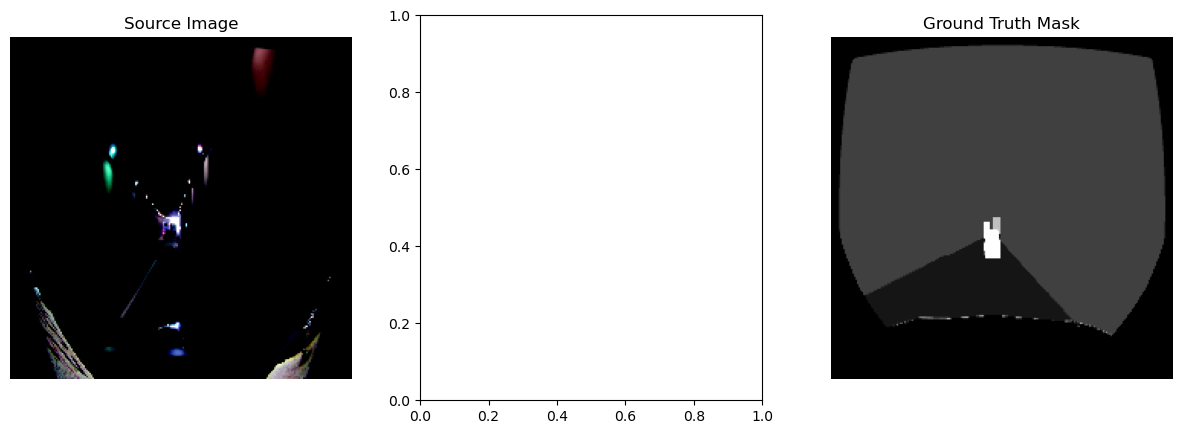

Hyperparamerters
LR = 0.001 | EP = 10, BATCH_SIZE = 16, N_CLASSES = 13, init_alpha = 0.00045, N_LABELS = 3


In [18]:

# 시각화를 위한 코드
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 원본 이미지 시각화
aaa=source_image[1].permute(1, 2, 0).cpu().numpy()
axes[0].imshow(aaa, cmap='gray')
#axes[0].imshow(np.transpose(source_image[0].cpu().numpy(), (1, 2, 0)))
axes[0].set_title('Source Image')
axes[0].axis('off')

# # 예측 결과 시각화
# pred_mask = torch.argmax(source_outputs[0], dim=1).cpu().numpy()
# axes[1].imshow(pred_mask.squeeze(), cmap='gray')
# axes[1].set_title('Predicted Mask')
# axes[1].axis('off')

# 실제 마스크 시각화
axes[2].imshow(source_mask[1].cpu().numpy(), cmap='gray')
axes[2].set_title('Ground Truth Mask')
axes[2].axis('off')

plt.show()

print("Hyperparamerters")
print(f"LR = {LR} | EP = {EP}, BATCH_SIZE = {BATCH_SIZE}, N_CLASSES = {N_CLASSES}, init_alpha = {ALPHA}, N_LABELS = {N_LABELS}")

In [19]:
#torch.save(model.state_dict(), './data/resnet34_1113_dropout_bumper.pth')

## Real Fish-Eye Image Test

In [20]:
model = Resnet34_Unet(n_classes=13).to(device)
model.load_state_dict(torch.load('./data/resnet34_1113_dropout_bumper.pth'), strict=False)


test_dataset = CustomDataset(csv_file='./data/896_csv/val_source_CL.csv', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 클래스별 IoU를 누적할 리스트 초기화
val_class_ious = []
fish_val_class_ious = []
val_epoch_loss = 0
val_seg_loss = 0
val_domain_loss = 0
# valid
with torch.no_grad():
    model.eval()

    for target_images, target_masks in tqdm(test_dataloader):
        label = 1.5
        #target_images, target_masks = apply_fisheye_distortion(target_images, target_masks, label)
        target_images = target_images.float().to(device)
        target_masks = target_masks.long().to(device)

        target_outputs = model(target_images)

        target_loss, target_seg_loss, target_domain_loss = loss_fn(target_outputs, target_masks, label, alpha = ALPHA)

        val_seg_loss +=  target_seg_loss.item()
        val_domain_loss += target_domain_loss.item()
        
        loss = target_loss

        val_epoch_loss += loss.item()

        # train 클래스별 IoU 계산
        target_outputs = torch.softmax(target_outputs[0], dim=1).cpu()
        target_outputs = torch.argmax(target_outputs, dim=1).numpy()

        for class_id in range(N_CLASSES):
            iou = calculate_iou_per_class(np.array(target_masks.cpu()), np.array(target_outputs), class_id)
            fish_val_class_ious.append(iou)

fish_val_class_ious = np.array(fish_val_class_ious).reshape(-1, N_CLASSES)
fish_val_class_ious = np.mean(fish_val_class_ious, axis=0)
print()
print("--IoU Scores Fish val--")
for class_id, iou in enumerate(fish_val_class_ious):
    print(f'Class{class_id:02d}: {iou:.4f}', end=" ")
    if (class_id+1) % 7 == 0:
        print()

# mIoU 계산
fish_val_mIoU = np.mean(fish_val_class_ious)
print()
print(f"Valid Seg Loss: {(val_seg_loss/len(test_dataloader))}",f"Valid dom Loss: {(val_domain_loss/len(test_dataloader))}")
print(f"Valid Loss: {(val_epoch_loss/len(test_dataloader))}")
print(f"Valid mIoU: {fish_val_mIoU}" )


  0%|          | 0/61 [00:00<?, ?it/s]/tmp/ipykernel_283930/288732703.py:26: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  domain_target = torch.LongTensor([domain_num] * batch_size).to(device)
100%|██████████| 61/61 [00:18<00:00,  3.34it/s]


--IoU Scores Fish val--
Class00: 0.0054 Class01: 0.0060 Class02: 0.0070 Class03: 0.0063 Class04: 0.0058 Class05: 0.0000 Class06: 0.0038 
Class07: 0.0048 Class08: 0.0021 Class09: 0.0082 Class10: 0.0000 Class11: 0.0000 Class12: 0.0005 
Valid Seg Loss: 27.7713044276003 Valid dom Loss: 0.0
Valid Loss: 27.7713044276003
Valid mIoU: 0.003830917323986924
